# 0. Imports and Dataset Load

In [1]:
from functools import partial
from pathlib import Path
import pickle

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import trange
import jax_dataloader.core as jdl
import optax

from rebayes.low_rank_filter.lofi import LoFiParams
from demos.showdown.classification import (
    permuted_mnist as core,
    classification_train as benchmark,
    hparam_tune_clf as hpt,
)

/home/peter0414/rebayes/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-12 04:12:09.410732: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-03-12 04:12:09.410853: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-03-12 04:12:09.410863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU w

In [2]:
data_kwargs = {
    'n_tasks': 6,
    'ntrain_per_task': 200,
    'nval_per_task': 1_000,
    'ntest_per_task': 1_000,
}

dataset = benchmark.load_permuted_mnist_dataset(**data_kwargs, fashion=True)

output_path = Path(Path.cwd(), 'output', 'permuted-mnist', 'toy-experiment-2')
output_path.mkdir(parents=True, exist_ok=True)

2023-03-12 04:12:15.152141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-03-12 04:12:15.152176: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
features = [400, 400, 10]
model_dict = benchmark.init_model(type='mlp', features=features)

In [4]:
(Xtr, Ytr), (Xval, Yval), (Xte, Yte) = dataset.values()

In [5]:
train = (Xtr, Ytr)
val = (Xval, Yval)
test = (Xte, Yte)

In [6]:
# # Measure average performance after 3 tasks
# val_after = 3
# X_warmup_tr = Xtr[:val_after*data_kwargs["ntrain_per_task"]]
# Y_warmup_tr = Ytr[:val_after*data_kwargs["ntrain_per_task"]]
# warmup_train = (X_warmup_tr, Y_warmup_tr)

# X_warmup_val = Xval[(val_after-1)*data_kwargs["nval_per_task"]:val_after*data_kwargs["nval_per_task"]]
# Y_warmup_val = Yval[(val_after-1)*data_kwargs["nval_per_task"]:val_after*data_kwargs["nval_per_task"]]
# warmup_val = (X_warmup_val, Y_warmup_val)

In [7]:
# ll_calback = partial(benchmark.eval_callback, evaluate_fn=benchmark.mnist_evaluate_ll)

In [8]:
ll_calback = partial(
    benchmark.osa_eval_callback, 
    evaluate_fn=lambda y_pred, y: -optax.softmax_cross_entropy(y_pred, y).mean(),
)

# 2. FDEKF

## 2.1 Hyperparam Tuning

In [36]:
pbounds={
    'log_init_cov': (-10, 0),
    'log_dynamics_weights': (-40, 0),
    'log_dynamics_cov': (-40, 0),
    'log_alpha': (-40, 0),
}
fdekf_model = 'fdekf'

In [37]:
fdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, val,
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'fdekf', callback_at_end=False,
)

In [38]:
%%time
fdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.349    | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -2.363    | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -2.341    | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -2.302    | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -2.124    | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -2.246    | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -2.275    | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -2.149    | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -2.273    | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -2.283    | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -2.365    | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -2.368    | -11.25    | 

## 2.2 Test-Set Evaluation

In [9]:
# fdekf_hparams = {
#     'initial_covariance': 0.030038025796567537,
#     'dynamics_weights': 0.9999255554555125,
#     'dynamics_covariance': 2.7613748742604826e-10,
#     'dynamics_covariance_inflation_factor': 2.663751310790857e-17
# }

In [39]:
fdekf_hparams = hpt.get_best_params(fdekf_optimizer, method=fdekf_model)
fdekf_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                         fdekf_hparams, model_dict['emission_mean_function'],
                                         model_dict['emission_cov_function'], 
                                         method="fdekf")

In [40]:
fdekf_hparams

{'initial_covariance': 0.025738212166516367,
 'dynamics_weights': 0.9999999670717279,
 'dynamics_covariance': 4.3868795283341816e-08,
 'dynamics_covariance_inflation_factor': 5.449850126915546e-17}

In [41]:
accuracy_fn = lambda logits, label: jnp.mean(logits.argmax(axis=-1) == label)
evaluate_accuracy = partial(
    benchmark.evaluate_function,
    loss_fn=accuracy_fn
)

In [42]:
def test_acc_callback(bel, pred_obs, t, x, y, bel_pred, i, **kwargs):
    X_test, y_test, apply_fn = kwargs["X_test"], kwargs["y_test"], kwargs["apply_fn"]
    ntest_per_batch = kwargs["ntest_per_batch"]
    
    prev_test_batch, curr_test_batch = i*ntest_per_batch, (i+1)*ntest_per_batch
    curr_X_test, curr_y_test = X_test[prev_test_batch:curr_test_batch], y_test[prev_test_batch:curr_test_batch]
    cum_X_test, cum_y_test = X_test[:curr_test_batch], y_test[:curr_test_batch]
    
    overall_accuracy = evaluate_accuracy(bel.mean, apply_fn, cum_X_test, cum_y_test)
    current_accuracy = evaluate_accuracy(bel.mean, apply_fn, curr_X_test, curr_y_test)
    task1_accuracy = evaluate_accuracy(bel.mean, apply_fn, X_test[:ntest_per_batch], y_test[:ntest_per_batch])
    result = {
        'overall': overall_accuracy,
        'current': current_accuracy,
        'task1': task1_accuracy,
    }
    return result

In [43]:
def evaluate_model(estimator, n_iter=5, bel=None):
    overall_accs, current_accs, task1_accs = [], [], []
    for i in trange(n_iter):
        # Load dataset with random permutation and random shuffle
        dataset = benchmark.load_permuted_mnist_dataset(**data_kwargs, key=i, fashion=True)
        (Xtr, Ytr), _, (Xte, Yte) = dataset.values()
        train_ds = jdl.ArrayDataset(Xtr, Ytr)
        train_loader = jdl.DataLoaderJax(
            train_ds, batch_size=data_kwargs["ntrain_per_task"], shuffle=False, drop_last=False
        )

        test_kwargs = {
            'X_test': Xte,
            'y_test': Yte,
            'ntest_per_batch': data_kwargs["ntest_per_task"],
            'apply_fn': model_dict["apply_fn"],
        }

        _, accs = estimator.scan_dataloader(
            train_loader, 
            callback=test_acc_callback, 
            bel=bel,
            callback_at_end=False,
            **test_kwargs
        )
        overall_accs.append(jnp.array([res['overall'] for res in accs]))
        current_accs.append(jnp.array([res['current'] for res in accs]))
        task1_accs.append(jnp.array([res['task1'] for res in accs]))
    
    overall_accs, current_accs, task1_accs = jnp.array(overall_accs), jnp.array(current_accs), jnp.array(task1_accs)
    overall_accs, current_accs, task1_accs = \
        overall_accs.reshape((n_iter, -1)), current_accs.reshape((n_iter, -1)), task1_accs.reshape((n_iter, -1))

    result = {
        'overall': overall_accs.mean(axis=0),
        'overall-std': overall_accs.std(axis=0),
        'current': current_accs.mean(axis=0),
        'current-std': current_accs.std(axis=0),
        'task1': task1_accs.mean(axis=0),
        'task1-std': task1_accs.std(axis=0),
    }
    
    return result

In [44]:
fdekf_res = evaluate_model(fdekf_estimator)

100%|██████████| 5/5 [06:08<00:00, 73.79s/it]


In [45]:
filename = f'fdekf_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(fdekf_res, f)

# 3. VDEKF

## 3.1 Hyperparam Tuning

In [46]:
vdekf_model = 'vdekf'

In [47]:
vdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, val,
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'vdekf', callback_at_end=False,
)

In [48]:
%%time
vdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.359    | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -2.35     | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -2.336    | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -2.302    | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -2.124    | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -2.246    | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -2.276    | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -2.149    | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -2.273    | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -2.283    | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -2.37     | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -2.363    | -11.25    | 

## 3.2 Test-Set Evaluation

In [17]:
# vdekf_hparams = {
#     'initial_covariance': 0.04324186101120577,
#     'dynamics_weights': 0.9999999996168594,
#     'dynamics_covariance': 1.2163607819592161e-08,
#     'dynamics_covariance_inflation_factor': 2.0847902905876572e-20
# }

In [49]:
vdekf_hparams = hpt.get_best_params(vdekf_optimizer, method=vdekf_model)
vdekf_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                      vdekf_hparams, model_dict['emission_mean_function'],
                                      model_dict['emission_cov_function'], 
                                      method="vdekf")

In [50]:
vdekf_hparams

{'initial_covariance': 0.038072988089450976,
 'dynamics_weights': 0.9999955754492725,
 'dynamics_covariance': 1.6544168943837722e-15,
 'dynamics_covariance_inflation_factor': 5.90556301930281e-13}

In [51]:
vdekf_res = evaluate_model(vdekf_estimator)

100%|██████████| 5/5 [06:13<00:00, 74.69s/it]


In [52]:
filename = f'vdekf_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(vdekf_res, f)

# 4. LoFi (Rank 2)

## 4.1 Hyperparam Tuning

In [53]:
lofi_2_params = LoFiParams(
    memory_size=2,
    diagonal_covariance=True,
)

In [54]:
pbounds={
    'log_init_cov': (-10, 0),
    'log_dynamics_weights': (-40, 0),
    'log_dynamics_cov': (-40, 0),
    'log_alpha': (-40, 0),
}

In [55]:
lofi_2_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_2_params,
)

In [56]:
%%time
lofi_2_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------


TypeError: osa_eval_callback() missing 5 required positional arguments: 'y_pred', 't', 'X', 'y', and 'bel_pred'

## 4.2 Test-Set Evaluation

In [95]:
# lofi_2_hparams = {
#     'initial_covariance': 0.015181455367452369,
#     'dynamics_weights': 0.999999938814697,
#     'dynamics_covariance': 4.2311825285784173e-07,
#     'dynamics_covariance_inflation_factor': 6.96219159113032e-17
# }

In [ ]:
lofi_2_hparams = hpt.get_best_params(lofi_2_optimizer, method='lofi')
lofi_2_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       lofi_2_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='lofi', lofi_params=lofi_2_params)

In [ ]:
lofi_2_hparams

{'initial_covariance': 0.015181455367452369,
 'dynamics_weights': 0.999999938814697,
 'dynamics_covariance': 4.2311825285784173e-07,
 'dynamics_covariance_inflation_factor': 6.96219159113032e-17}

In [ ]:
lofi_2_res = evaluate_model(lofi_2_estimator)

100%|██████████| 5/5 [10:42<00:00, 128.52s/it]


In [ ]:
filename = f'lofi_2_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_2_res, f)

# 5. LoFi (Rank 5)

## 5.1 Hyperparam Tuning

In [ ]:
pbounds={
    'log_init_cov': (-10, 0),
    'log_dynamics_weights': (-40, 0),
    'log_dynamics_cov': (-40, 0),
    'log_alpha': (-40, 0),
}

In [10]:
lofi_5_params = LoFiParams(
    memory_size=5,
    diagonal_covariance=True,
)

In [11]:
lofi_5_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', callback_at_end=False, lofi_params=lofi_5_params
)

In [12]:
%%time
lofi_5_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.209    | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -2.306    | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -2.3      | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -2.302    | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -2.091    | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -2.24     | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -2.271    | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -2.122    | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -2.272    | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -2.283    | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -2.366    | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -2.353    | -11.25    | 

## 5.2 Test-Set Evaluation

In [15]:
lofi_5_hparams = {
    'initial_covariance': 0.03460532114643691,
    'dynamics_weights': 0.9999999617101771,
    'dynamics_covariance': 9.562985732849858e-07,
    'dynamics_covariance_inflation_factor': 2.1083969131970902e-15
}

In [16]:
# lofi_5_hparams = hpt.get_best_params(lofi_5_optimizer, method='lofi')
lofi_5_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       lofi_5_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='lofi', lofi_params=lofi_5_params)

In [17]:
lofi_5_hparams

{'initial_covariance': 0.03460532114643691,
 'dynamics_weights': 0.9999999617101771,
 'dynamics_covariance': 9.562985732849858e-07,
 'dynamics_covariance_inflation_factor': 2.1083969131970902e-15}

In [22]:
lofi_5_res = evaluate_model(lofi_5_estimator)

100%|██████████| 5/5 [08:08<00:00, 97.61s/it] 


In [23]:
filename = f'lofi_5_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_5_res, f)

# 6. LoFi (Rank 10)

## 6.1 Hyperparam Tuning

In [ ]:
lofi_10_params = LoFiParams(
    memory_size=10,
    diagonal_covariance=True,
)

In [ ]:
lofi_10_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, val,
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', callback_at_end=False, lofi_params=lofi_10_params,
)

In [ ]:
%%time
lofi_10_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.241    | -4.156    | -20.57    | -36.75    | -1.385    |
| 2         | -2.21     | -4.1      | -8.632    | -13.6     | -7.135    |
| 3         | -2.296    | -4.412    | -36.96    | -11.68    | -7.123    |
| 4         | -2.295    | -43.89    | -30.7     | -7.996    | -6.94     |
| 5         | -2.127    | -46.5     | -18.34    | -20.76    | -3.606    |
| 6         | -2.289    | -16.14    | -15.64    | -28.05    | -6.47     |
| 7         | -2.266    | -21.47    | -26.01    | -6.946    | -0.8171   |
| 8         | -2.243    | -44.71    | -46.98    | -20.16    | -1.284    |
| 9         | -2.281    | -38.68    | -23.24    | -43.2     | -5.905    |
| 10        | -2.272    | -42.4     | -28.51    | -10.36    | -5.523    |
| 11        | -2.326    | -41.11    | -4.537    | -22.73    | -8.895    |
| 12        | -2.359    | -14.06    | 

## 6.2 Test-Set Evaluation

In [41]:
# lofi_10_hparams = {
#     'initial_covariance': 0.02306763740595599,
#     'dynamics_weights': 0.99998931023871,
#     'dynamics_covariance': 1.4819756308406537e-10,
#     'dynamics_covariance_inflation_factor': 8.279932509041775e-19
# }

In [ ]:
lofi_10_hparams = hpt.get_best_params(lofi_10_optimizer, method='lofi')
lofi_10_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                        lofi_10_hparams, model_dict['emission_mean_function'],
                                        model_dict['emission_cov_function'], 
                                        method='lofi', lofi_params=lofi_10_params)

In [ ]:
lofi_10_hparams

{'initial_covariance': 0.03953765008343703,
 'dynamics_weights': 0.9999956277662314,
 'dynamics_covariance': 1.861544352632284e-10,
 'dynamics_covariance_inflation_factor': 2.151109684974667e-18}

In [ ]:
lofi_10_res = evaluate_model(lofi_10_estimator)

100%|██████████| 5/5 [10:48<00:00, 129.78s/it]


In [ ]:
filename = f'lofi_10_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_10_res, f)

# 7. LoFi (Rank 20)

## 7.1 Hyperparam Tuning

In [29]:
lofi_20_params = LoFiParams(
    memory_size=20,
    diagonal_covariance=True,
)

In [30]:
lofi_20_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, train, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', callback_at_end=False, lofi_params=lofi_20_params
)

In [31]:
%%time
lofi_20_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.169    | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -2.311    | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -2.3      | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -2.302    | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -2.067    | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -2.24     | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -2.268    | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -2.083    | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -2.272    | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -2.283    | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -2.35     | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -2.366    | -11.25    | 

## 7.2 Test-Set Evaluation

In [49]:
lofi_20_hparams = {
    'initial_covariance': 0.027487950643458332,
    'dynamics_weights': 0.9999999724240787,
    'dynamics_covariance': 6.50688261717573e-07,
    'dynamics_covariance_inflation_factor': 2.4299990725436893e-15
}

In [32]:
# lofi_20_hparams = hpt.get_best_params(lofi_20_optimizer, method='lofi')
lofi_20_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                        lofi_20_hparams, model_dict['emission_mean_function'],
                                        model_dict['emission_cov_function'], 
                                        method='lofi', lofi_params=lofi_20_params)

In [33]:
lofi_20_hparams

{'initial_covariance': 0.027487950643458332,
 'dynamics_weights': 0.9999999724240787,
 'dynamics_covariance': 6.50688261717573e-07,
 'dynamics_covariance_inflation_factor': 2.4299990725436893e-15}

In [34]:
lofi_20_res = evaluate_model(lofi_20_estimator)

100%|██████████| 5/5 [08:35<00:00, 103.10s/it]


In [35]:
filename = f'lofi_20_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_20_res, f)

# 8. Online Gradient Descent

## 8.1 Hyperparam Tuning

In [14]:
rsgd_pbounds = {
    'learning_rate': (1e-8, 1e-1),
}

In [15]:
ogd_params = {
    'loss_fn': optax.softmax_cross_entropy,
    'buffer_size': 1,
    'dim_output': 10
}

In [16]:
ogd_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], rsgd_pbounds, 314, train, val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'sgd', callback_at_end=False, **ogd_params
)

In [17]:
%%time
ogd_optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | learni... |
-------------------------------------
| 1         | -2.168    | 0.09169   |
| 2         | -1.853    | 0.05885   |
| 3         | -1.583    | 0.0265    |
| 4         | -2.014    | 0.07832   |
| 5         | -2.171    | 0.0918    |
| 6         | -2.06     | 0.08274   |
| 7         | -2.001    | 0.0728    |
| 8         | -1.568    | 0.02605   |
| 9         | -2.151    | 0.09118   |
| 10        | -1.567    | 0.02608   |
| 11        | -1.79     | 0.05333   |
| 12        | -1.749    | 0.0489    |
| 13        | -1.72     | 0.0448    |
| 14        | -1.68     | 0.04089   |
| 15        | -1.65     | 0.03725   |
| 16        | -1.637    | 0.0338    |
| 17        | -2.321    | 1e-08     |
| 18        | -1.537    | 0.01377   |
| 19        | -1.557    | 0.01074   |
| 20        | -1.53     | 0.01733   |
| 21        | -1.541    | 0.02031   |
| 22        | -1.628    | 0.007328  |
| 23        | -2.208    | 0.1       |
| 24        | -1.545    | 0.02306   |
| 25        

## 8.2 Test-Set Evaluation

In [20]:
ogd_hparams = {
    'learning_rate': 0.017327968047982676
}

In [21]:
# ogd_hparams = hpt.get_best_params(ogd_optimizer, method='sgd')
ogd_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                    ogd_hparams, model_dict['emission_mean_function'],
                                    model_dict['emission_cov_function'], 
                                    method='sgd', **ogd_params)

In [22]:
ogd_hparams

{'learning_rate': 0.017327968047982676}

In [27]:
ogd_res = evaluate_model(ogd_estimator)

100%|██████████| 5/5 [01:33<00:00, 18.64s/it]


In [28]:
filename = f'ogd_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(ogd_res, f)

# 9. SGD-RB (Rank 10)

## 9.1 Hyperparam Tuning

In [10]:
rsgd_pbounds = {
    'learning_rate': (1e-8, 1e-1),
}

In [11]:
sgd_10_params = {
    'loss_fn': optax.softmax_cross_entropy,
    'buffer_size': 10,
    'dim_output': 10
}

In [12]:
sgd_10_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], rsgd_pbounds, 314, train, val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'sgd', callback_at_end=False, **sgd_10_params
)

In [13]:
%%time
sgd_10_optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | learni... |
-------------------------------------
| 1         | -1.307e+2 | 0.09169   |
| 2         | -7.646e+2 | 0.05885   |
| 3         | -2.031    | 0.0265    |
| 4         | -8.642e+3 | 0.07832   |
| 5         | -1.724e+2 | 0.0918    |
| 6         | -2.005e+3 | 0.08274   |
| 7         | -1.463e+2 | 0.0728    |
| 8         | -2.108    | 0.02605   |
| 9         | -9.074e+2 | 0.09118   |
| 10        | -2.016    | 0.02608   |
| 11        | -1.356e+2 | 0.05143   |
| 12        | -2.518    | 0.04381   |
| 13        | -3.298e+1 | 0.03607   |
| 14        | -3.492e+3 | 0.1       |
| 15        | -1.576    | 0.0155    |
| 16        | -1.365    | 0.007049  |
| 17        | -2.321    | 1e-08     |
| 18        | -1.584e+2 | 0.0655    |
| 19        | -1.767    | 0.02016   |
| 20        | -2.242    | 0.03184   |
| 21        | -1.42     | 0.01121   |
| 22        | -2.581    | 0.04761   |
| 23        | -2.565    | 0.03992   |
| 24        | -3.92e+03 | 0.05524   |
| 25        

## 9.2 Test-Set Evaluation

In [77]:
sgd_10_hparams = {
    'learning_rate': 0.007048603105245366
}

In [14]:
# sgd_10_hparams = hpt.get_best_params(sgd_10_optimizer, method='sgd')
sgd_10_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       sgd_10_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='sgd', **sgd_10_params)

In [15]:
sgd_10_hparams

{'learning_rate': 0.007048603105245366}

In [20]:
sgd_10_res = evaluate_model(sgd_10_estimator)

100%|██████████| 5/5 [01:34<00:00, 18.85s/it]


In [21]:
filename = f'sgd_10_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(sgd_10_res, f)

# 11. Model Comparison

In [57]:
# Load Results
from pathlib import Path

output_path = Path(Path.cwd(), 'output', 'permuted-mnist', 'toy-experiment-2')
model_types = [
    'fdekf',
    'vdekf',
    # 'lofi_1', 
    'lofi_5', 
    'lofi_10',
    # 'lofi_20', 
    'ogd', 
    'sgd_10',
]
results = {}
for model_type in model_types:
    filename = f'{model_type}_result.pkl'
    with open(Path(output_path, filename), "rb") as f:
        results[model_type] = pickle.load(f)

In [58]:
boundaries = [i for i in range(200, (200*6)+1, 200)]
n_iter = 5

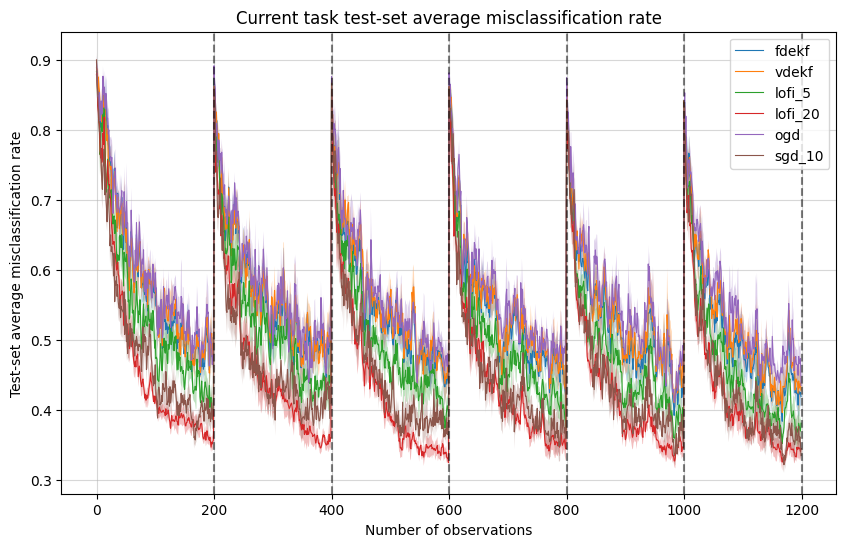

In [59]:
fig, ax = plt.subplots(figsize=(10, 6))
for key, value in results.items():
    ax.plot(1.0 - value['current'], label=key, linewidth=0.8)
    ax.fill_between(
        jnp.arange(value['current'].shape[0]),
        1.0 - value['current'] - (value['current-std'] / jnp.sqrt(n_iter)),
        1.0 - value['current'] + (value['current-std'] / jnp.sqrt(n_iter)),
        alpha=0.3
    )
# Task boundaries
for b in boundaries:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Current task test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();

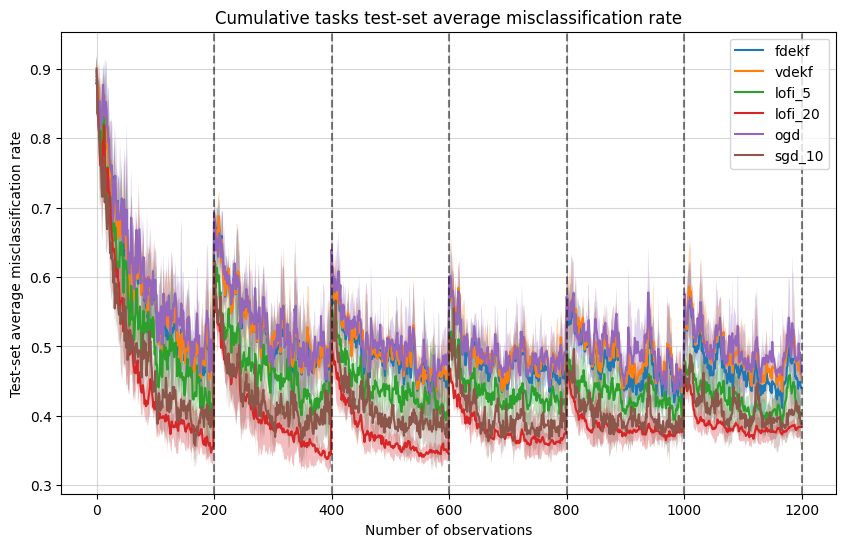

: 

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))
for key, value in results.items():
    ax.plot(1.0 - value['overall'], label=key)
    ax.fill_between(
        jnp.arange(value['overall'].shape[0]),
        1.0 - value['overall'] - value['overall-std'],
        1.0 - value['overall'] + value['overall-std'],
        alpha=0.3
    )
# Task boundaries
for b in boundaries:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Cumulative tasks test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();

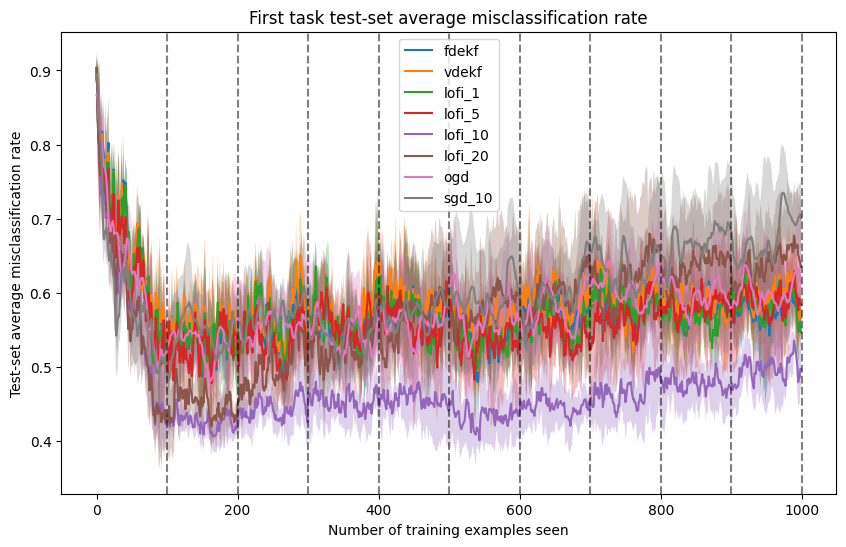

In [89]:
fig, ax = plt.subplots(figsize=(10, 6))
for key, val in results.items():
    ax.plot(1.0 - val['task1'], label=key)
    ax.fill_between(
        jnp.arange(val['task1'].shape[0]),
        1.0 - val['task1'] - val['task1-std'],
        1.0 - val['task1'] + val['task1-std'],
        alpha=0.3
    )
# Task boundaries
for b in boundaries:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'First task test-set average misclassification rate')
ax.legend();

# Load Results

In [112]:
# Load Results
from pathlib import Path

output_path2 = Path(Path.cwd(), 'output', 'permuted-mnist', 'experiment-2')
model_types = [
    'fdekf', 
    'vdekf', 
    'lofi_1', 
    'lofi_5', 
    'lofi_10',
    'lofi_20', 
    'ogd', 
    # 'sgd_10',
    # 'sgd_20'
]
results_100 = {}
for model_type in model_types:
    filename = f'{model_type}_result.pkl'
    with open(Path(output_path2, filename), "rb") as f:
        results_100[model_type] = pickle.load(f)

In [113]:
n_iter = 5

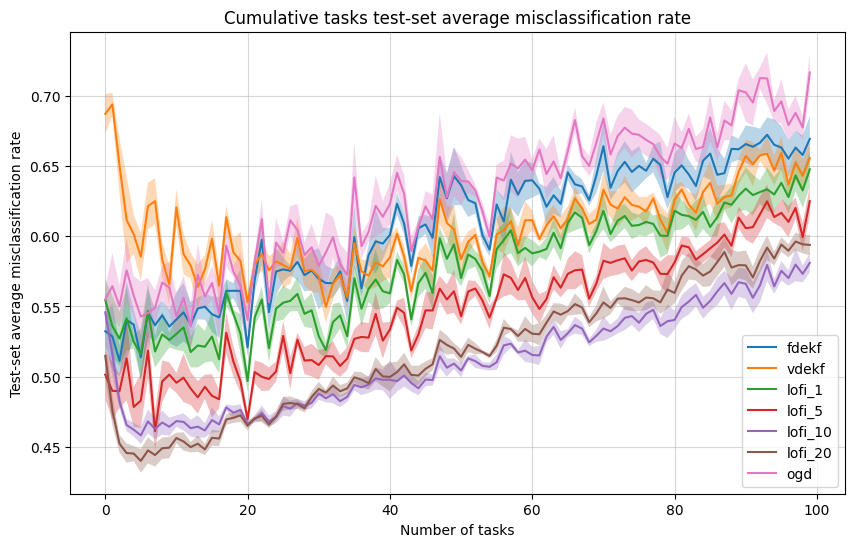

In [114]:
fig, ax = plt.subplots(figsize=(10, 6))
for key, val in results_100.items():
    ax.plot(1.0 - val['overall'], label=key)
    ax.fill_between(
        jnp.arange(val['overall'].shape[0]),
        1.0 - val['overall'] - val['overall-std'] / jnp.sqrt(n_iter),
        1.0 - val['overall'] + val['overall-std'] / jnp.sqrt(n_iter),
        alpha=0.3
    )
# Task boundaries
ax.set_xlabel('Number of tasks')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Cumulative tasks test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();

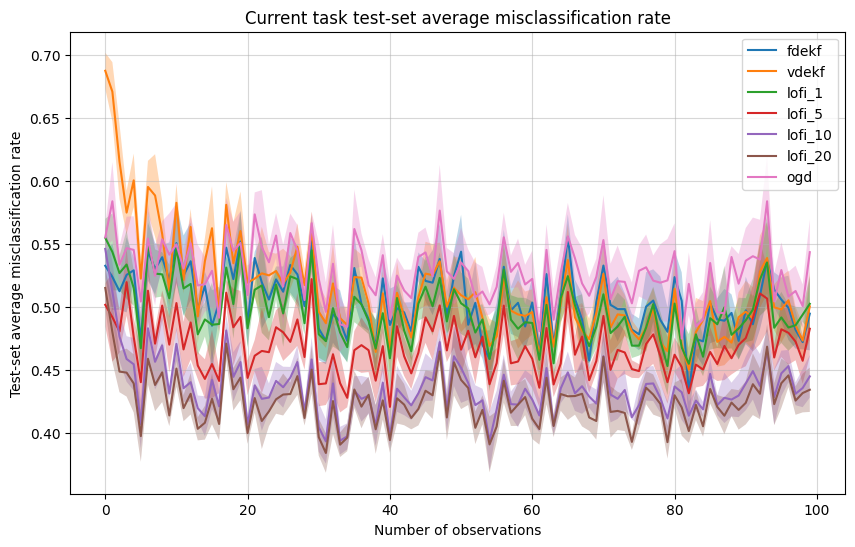

In [115]:
fig, ax = plt.subplots(figsize=(10, 6))
for key, val in results_100.items():
    ax.plot(1.0 - val['current'], label=key)
    ax.fill_between(
        jnp.arange(val['current'].shape[0]),
        1.0 - val['current'] - val['current-std'] / jnp.sqrt(n_iter),
        1.0 - val['current'] + val['current-std'] / jnp.sqrt(n_iter),
        alpha=0.3
    )
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Current task test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();

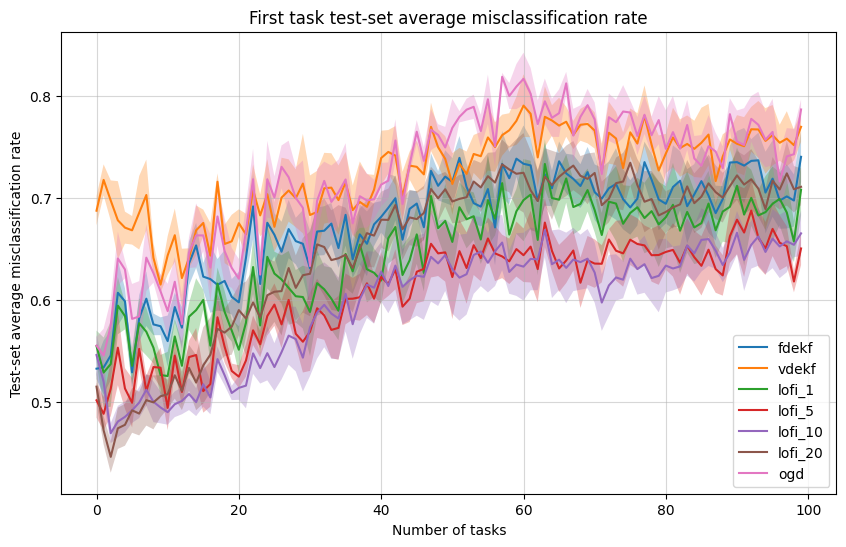

In [116]:
fig, ax = plt.subplots(figsize=(10, 6))
for key, val in results_100.items():
    ax.plot(1.0 - val['task1'], label=key)
    ax.fill_between(
        jnp.arange(val['task1'].shape[0]),
        1.0 - val['task1'] - val['task1-std'] / jnp.sqrt(n_iter),
        1.0 - val['task1'] + val['task1-std'] / jnp.sqrt(n_iter),
        alpha=0.3
    )
ax.set_xlabel('Number of tasks')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'First task test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();